# Motivation
In my first notebook about JPX, I built a simple neural network based on OHLCV features:[**【JPX】Neural Network Starter - Keras**](https://www.kaggle.com/code/daosword/jpx-neural-network-starter-keras). Before diving deeper into the deep learning world with more complex NN models, I am curious about what level of performance a GBRT model can achieve in this competition since I have seen a lot of kagglers using LightGBM, XGBoost, CatBoost, etc.  
This noetbook is maininly motivated by a research paper: ***[Do We Really Need Deep Learning Models for Time Series Forecasting?](https://arxiv.org/abs/2101.02118)*** In the study, the authors investigated and reproduced a number of recent deep learning frameworks for time series forecasting and compared them to a rolling forecast GBRT on various datasets:
> "The experimental results evidence that a conceptually simpler model, like the GBRT, can compete and sometimes outperform state-of-the-art DNN models by efficiently feature-engineering the input and output structures of the GBRT."

Their window-based input setting for GBRT models is illustrated as the figure below: 
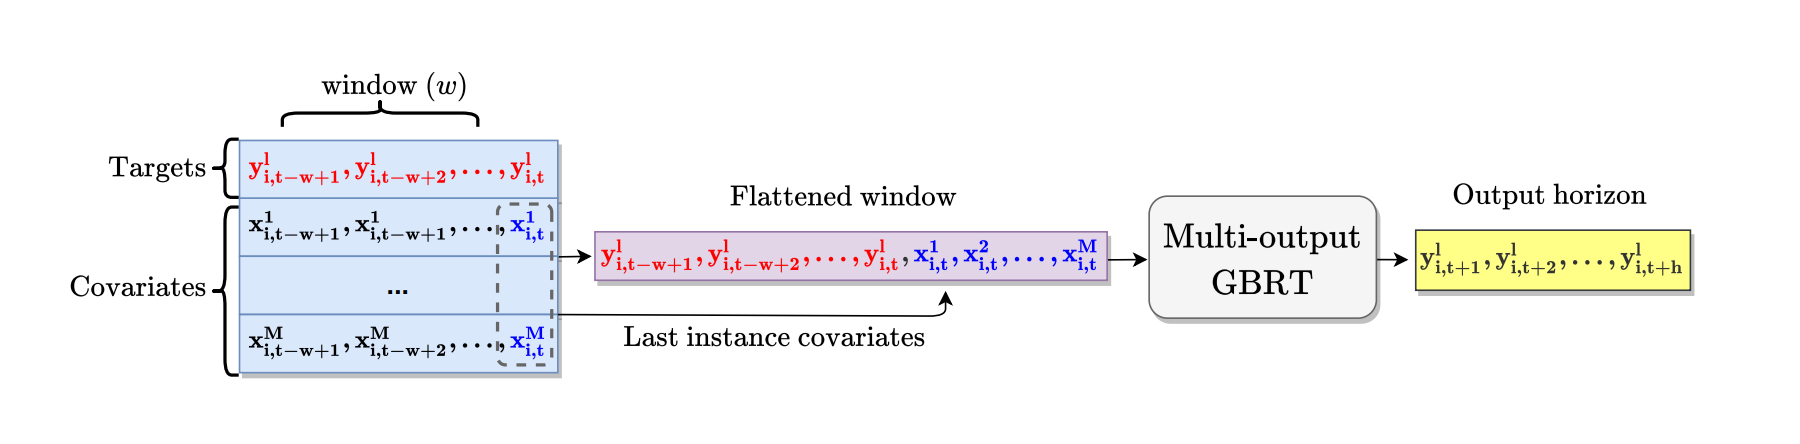  
In the followings of this notebook, I will try to replicate the core modeling pipeline above, and modify it so that it could adjust to our JPX data and context.  
This notebook focuses on training phase, and another notebook: [**【JPX】Window-based Regression with XGBoost | Infer**](https://www.kaggle.com/code/daosword/jpx-window-based-regression-with-xgboost-infer) will do model inference and submission.

# Setup

In [ ]:
import pandas as pd
import numpy as np
import random
import gc
import os
from tqdm.notebook import tqdm
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

In [ ]:
# Set random seed
seed = 30
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Load Data

In [ ]:
%%time
df_prices = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
df_prices

In [ ]:
# Choose data from 2017 to 2021 for training and testing
df_prices = df_prices[df_prices.Date >= "2017-01-01"].reset_index(drop=True)
df_prices

# Data Preprocessing

Except for OHLCV features, this time I add several extra features.

In [ ]:
# Date features
def get_date_features(df, date_col):
    """
    Add datetime features to original dataframe
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['week'] = df[date_col].dt.isocalendar().week
    df['day'] = df[date_col].dt.day
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['dayofyear'] = df[date_col].dt.dayofyear
    df[date_col] = df[date_col].astype(str)
    
    return df

In [ ]:
# Check results
get_date_features(df_prices, 'Date').head()

In [ ]:
# Shadow features - https://www.kaggle.com/code/satoshidatamoto/jpx-xgboost-with-gpu-fit-in-1-min
def get_shadow_features(df):
    """
    Add shadow features to original dataframe
    """
    df = df.copy()
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    
    return df

In [ ]:
# Check results
get_shadow_features(df_prices).head()

The main preprocessing function below does several jobs for us:
* add date/shadow features
* split train and test data
* fill missing values
* transform raw features into a flattened window shape  

I borrow some code from the paper's official Github: [GBRT-for-TSF](https://github.com/Daniela-Shereen/GBRT-for-TSF), but restructure them to suit for our data.

In [ ]:
def preprocessing(df, date_col, feature_col, target_col, group_col, training_cutoff, num_periods_input, num_periods_output, 
                  fill_missing_train=False, fill_missing_test=False, training=True, backward_gap=1):
    """
    Preprocess training and testing data
    """
    # Add date features
    print("Adding date features..")
    df = get_date_features(df, date_col)
    date_features = ['year', 'month', 'week', 'day', 'dayofweek', 'dayofyear']
    
    # Add shadow features
    print("Adding shadow features..")
    df = get_shadow_features(df)
    shadow_features = ['upper_shadow', 'lower_shadow']
    
    # Train test split
    print("Spliting train and test data..")
    real_training_cutoff = df[df[date_col] >= training_cutoff][date_col].values[0]
    all_dates = sorted(df.Date.unique().tolist())
    cutoff_idx = all_dates.index(real_training_cutoff)
    training_cutoff_adjust = all_dates[cutoff_idx - num_periods_input - backward_gap]
    train = df[df[date_col] < training_cutoff_adjust]
    test = df[df[date_col] >= training_cutoff_adjust]
        
    # Get all features and target
    all_features = feature_col + date_features + shadow_features
    number_of_features = len(all_features)
    
    # Process missing training targets
    df_train = train[[group_col] + all_features + [target_col]].copy()
    df_train = df_train.dropna(subset=[target_col]).reset_index(drop=True).copy()
    df_test = test[[group_col] + all_features + [target_col]].copy()
            
    x_batches = []
    y_batches = []
    x_testbatches = []
    y_testbatches = []
    
    # Create train and test batches
    print("Constructing training and testing batches..")
    for group in tqdm(df[group_col].unique()):
        limit = num_periods_output + num_periods_input + backward_gap
        
        ############################ TRAIN windows ############################
        train = df_train[df_train[group_col] == group].copy().reset_index(drop=True)
        train = train.drop(group_col, axis=1)
        
        # Process missing features in training data
        if fill_missing_train:
            train = train.fillna(method='ffill')
        else:
            train = train.dropna()
        
        if training:
            y_train = train[target_col].values.astype('float32')
            x_train = train[all_features].values
            y_train = np.reshape(y_train, (len(y_train), 1))
            train = np.append(x_train, y_train, axis=1)
            
            end_train = len(train)
            start_train = 0
            next_train = 0

            while start_train + limit <= end_train:
                next_train = start_train + num_periods_input
                history_targets = train[start_train:next_train, -1].reshape(num_periods_input, 1)
                covariates = train[start_train+1+backward_gap:next_train+1+backward_gap, :-1]
                x_batches.append(np.append(covariates, history_targets, axis=1))
                y_batches.append(train[next_train+backward_gap:next_train+backward_gap+num_periods_output, -1])
                start_train = start_train + 1

        ############################ TEST windows ############################
        test = df_test[df_test[group_col] == group].copy().reset_index(drop=True)
        test = test.drop(group_col, axis=1)
        
        # Process missing features in training data
        if fill_missing_test:
            test = test.fillna(method='ffill')
        else:
            test = test.dropna()
        
        y_test = test[target_col].values.astype('float32')
        x_test = test[all_features].values
        y_test = np.reshape(y_test, (len(y_test), 1))
        test = np.append(x_test, y_test, axis=1)

        end_test = len(test)
        start_test = 0
        next_test = 0

        while start_test + limit <= end_test:
            next_test = start_test + num_periods_input
            history_targets = test[start_test:next_test, -1].reshape(num_periods_input, 1)
            covariates = test[start_test+1+backward_gap:next_test+1+backward_gap, :-1]
            x_testbatches.append(np.append(covariates, history_targets, axis=1))
            y_testbatches.append(test[next_test+backward_gap:next_test+backward_gap+num_periods_output, -1])
            start_test = start_test + 1
    
    if training:
        x_batches = np.asarray(x_batches)
        y_batches = np.asarray(y_batches)
        y_batches = y_batches.reshape(-1, num_periods_output, 1)
        print("X_train: {}, y_train: {}".format(x_batches.shape, y_batches.shape))
    
    x_testbatches = np.asarray(x_testbatches)
    y_testbatches = np.asarray(y_testbatches)
    y_testbatches = y_testbatches.reshape(-1, num_periods_output, 1)
    print("X_test:  {}, y_test:  {}".format(x_testbatches.shape, y_testbatches.shape))
    
    if training:
        return x_batches, y_batches, x_testbatches, y_testbatches
    return x_testbatches, y_testbatches

In [ ]:
%%time
feature_col = ['Open', 'High', 'Low', 'Close', 'Volume']
num_periods_input = 5
num_periods_output = 1
X_train, y_train, X_test, y_test = preprocessing(
    df=df_prices, 
    date_col='Date', 
    feature_col=feature_col, 
    target_col='Target', 
    group_col='SecuritiesCode', 
    training_cutoff='2021-01-01', 
    num_periods_input=num_periods_input, 
    num_periods_output=num_periods_output,
    fill_missing_train=False,
    fill_missing_test=True,
    training=True,
    backward_gap=1,
)

In [ ]:
%%time
# Shuffle minibatches X and Y together
combined = list(zip(X_train, y_train))
random.shuffle(combined)
X_train_shuffled, y_train_shuffled = zip(*combined)
del X_train, y_train
gc.collect()

In [ ]:
# Change each window into training instance 
All_Training_Instances = [] 
for i in tqdm(range(len(X_train_shuffled))):
    hold = []
    for j in range(len(X_train_shuffled[i])):
        if j == (len(X_train_shuffled[i])-1):
            hold = np.concatenate((hold, X_train_shuffled[i][j][:]), axis=None)
        else:
            hold = np.concatenate((hold, X_train_shuffled[i][j][-1]), axis=None)
    All_Training_Instances.append(hold)
    
print(len(All_Training_Instances[0]))

In [ ]:
# Change each window into test instance
All_Testing_Instances = []
for i in tqdm(range(len(X_test))):
    hold = []
    for j in range(len(X_test[i])):
        if j == (len(X_test[i])-1):
            hold = np.concatenate((hold, X_test[i][j][:]), axis=None)
        else:
            hold = np.concatenate((hold, X_test[i][j][-1]), axis=None)
    All_Testing_Instances.append(hold)
print(len(All_Testing_Instances[0]))

In [ ]:
# Reshape train data
All_Training_Instances = np.reshape(All_Training_Instances, (len(All_Training_Instances), len(All_Training_Instances[0])))
y_train_shuffled = np.reshape(y_train_shuffled, (len(y_train_shuffled), num_periods_output))

# Reshape test data
All_Testing_Instances = np.reshape(All_Testing_Instances, (len(All_Testing_Instances), len(All_Testing_Instances[0])))
y_test = np.reshape(y_test, (len(y_test), num_periods_output))

# XGBoost Model

## Training

In [ ]:
# XGBoost model
model = xgb.XGBRegressor(
    learning_rate=0.01,         
    n_estimators=420,
    max_depth=6,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=0.9,
    seed=42,
    silent=False,
    tree_method='gpu_hist',
)

In [ ]:
%%time
# Fit multioutput regressor
multioutput = MultiOutputRegressor(model).fit(All_Training_Instances, y_train_shuffled)
print('Fitting Done!')

## Evaluation

In [ ]:
# Define evaluation metrics

## JPX Competition Metric - https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

## MSE
def calc_mse(y_test, y_pred):
    return np.mean((y_pred - y_test)**2)

## MAE
def calc_mae(y_test, y_pred):
    return np.mean(np.abs(y_pred - y_test))

## IC & RankIC
def _correlation(df: pd.DataFrame, truth_col: str, pred_col: str, method: str, groupby: str = None) -> float:
    if groupby:
        corr_df = df.groupby(groupby)[[truth_col, pred_col]].corr(method=method)
        return corr_df.loc[(slice(None), truth_col), pred_col].mean()
    return df[[truth_col, pred_col]].corr(method=method).iloc[0, 1]

def spearman_corr(df: pd.DataFrame, truth_col: str, pred_col: str, groupby: str = None) -> float:
    """Spearman (Rank) correlation for regression problem

    Args:
        df (pd.DataFrame): contains truth_col, pred_col and (optinally) groupby columns
        truth_col (str): truth column
        pred_col (str): prediction column
        groupby (str, optional): groupby column. Defaults to None.

    Returns:
        float: correlation
    """
    return _correlation(df, truth_col, pred_col, 'spearman', groupby)

def pearson_corr(df: pd.DataFrame, truth_col: str, pred_col: str, groupby: str = None) -> float:
    """Pearson correlation for regression problem

    Args:
        df (pd.DataFrame): contains truth_col, pred_col and (optinally) groupby columns
        truth_col (str): truth column
        pred_col (str): prediction column
        groupby (str, optional): groupby column. Defaults to None.

    Returns:
        float: correlation
    """
    return _correlation(df, truth_col, pred_col, 'pearson', groupby)

In [ ]:
# Get predictions on test data
pred_df = df_prices[df_prices['Date']>='2021-01-01'][['Date', 'SecuritiesCode', 'Target']].copy().reset_index(drop=True)
prediction = multioutput.predict(All_Testing_Instances)
pred_df['Target_Pred'] = prediction
pred_df['Rank'] = pred_df.groupby('Date')['Target_Pred'].rank(ascending=False, method='first').astype(int) - 1
pred_df

In [ ]:
sharpe_ratio = calc_spread_return_sharpe(pred_df, portfolio_size=1)
print('Sharpe ratio: ', sharpe_ratio)
mse = calc_mse(pred_df['Target'], pred_df['Target_Pred'])
print('MSE: ', mse)
mae = calc_mae(pred_df['Target'], pred_df['Target_Pred'])
print('MAE: ', mae)
ic = pearson_corr(pred_df, 'Target', 'Target_Pred', 'Date')
print('IC(Pearson correlation):', ic)
rankic = spearman_corr(pred_df, 'Target', 'Target_Pred', 'Date')
print('RankIC(Spearman correlation)', rankic)

In [ ]:
# Save model
import joblib
joblib.dump(multioutput, 'JPX_xgboost_2017_2021.pkl')

# Reference
- **"Do We Really Need Deep Learning Models for Time Series Forecasting?"**
  - paper: https://arxiv.org/abs/2101.02118
  - code: https://github.com/Daniela-Shereen/GBRT-for-TSF
- [🔥 JPX: Xgboost with GPU - Fit in 1 Min 🔥](https://www.kaggle.com/code/satoshidatamoto/jpx-xgboost-with-gpu-fit-in-1-min) By @satoshidatamoto